In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2


In [2]:
import time
import datetime
from tsai.basics import *
import sktime
import sklearn

from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *

from scipy.io import loadmat
from data_utils import get_data
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from utils import cluster_acc

In [3]:

train_data = loadmat('earthb.mat')
all_data = train_data['images']
all_target = train_data['labels']

# load data
x_train, x_valid, x_test, y_train, y_valid, y_test, splits, splits_test = get_data(all_data, all_target, dataset='eq', seed=1)
print(x_train.shape, x_valid.shape, x_test.shape)
# set contains training and validation
X = np.concatenate([x_train, x_valid])
y = np.concatenate([y_train, y_valid])



(13883, 3, 2000) (1543, 3, 2000) (6612, 3, 2000)


In [4]:

start = time.time()
mrf = MiniRocketFeatures(x_train.shape[1], x_train.shape[2]).to(default_device())
mrf.fit(x_train)

X_feat = get_minirocket_features(X, mrf, chunksize=512, to_np=True).reshape(X.shape[0], -1)

print("feature extract time", time.time() - start)


feature extract time 30.168593406677246


In [5]:
X_feat.shape

(15426, 9996)

In [6]:
start = time.time()

model = KMeans(n_clusters=3)
y_pred = model.fit_predict(X_feat)


print("Kmeans training time", time.time() - start)

Kmeans training time 67.13305473327637


In [7]:
from utils import plotter




In [8]:
start = time.time()

X_feat = get_minirocket_features(x_test, mrf, chunksize=512, to_np=True).reshape(x_test.shape[0], -1)
y_pred = model.predict(X_feat)
print('test accuracy')
train_valid_acc, aligned_pred = cluster_acc(y_test, y_pred)
end = time.time()
print("Datashape, train, valid, test: ", x_train.shape, x_valid.shape, x_test.shape)
print("total time(evaluate cluster accuracy) takes %d seconds, " % (end - start), str(datetime.timedelta(seconds=end-start)))

test accuracy
[0 1 2] [1 2 0]
[[1477 1428    0]
 [ 168    4 2063]
 [1322  149    1]]
precision recall  F1 score in micro: (0.7279189352692075, 0.7279189352692075, 0.7279189352692075, None)
precision recall  F1 score in macro: (0.7709021989133462, 0.7827697413483805, 0.7306783589648793, None)
precision recall  F1 score in weighted: (0.8086785006962894, 0.7279189352692075, 0.7191036449769106, None)
Datashape, train, valid, test:  (13883, 3, 2000) (1543, 3, 2000) (6612, 3, 2000)
total time(evaluate cluster accuracy) takes 10 seconds,  0:00:10.461295


In [9]:
X_feat.shape

(6612, 9996)

In [10]:
#  y         = [ 0        1      2]
target_names = ['blast', 'eq', 'noise']

In [11]:
from sklearn.manifold import TSNE


In [12]:
feature_2d = TSNE(n_components=2, random_state=123).fit_transform(X_feat)

/home/xyang2/conda/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/xyang2/conda/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [13]:
feature_2d.shape

(6612, 2)

In [14]:
def plotter(feature, pred, y, target_names, acc, title, arg, vis=False, anchors=None):
    """
    function to visualize the outputs of t-SNE
    """
    if feature.shape[1] != 2:
        feature_2d = TSNE(n_components=2, random_state=123).fit_transform(feature)
    else:
        feature_2d = feature

    # choose a color palette with seaborn.
    colors = ['navy', 'turquoise', 'darkorange']
    anchor_colors = ['red', 'purple']
    lw = 2
    # create a scatter plot.
    # if y.sum() != 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))
    plt.suptitle('%s Acc %f' % (title, acc))
    
    # ax = f.add_subplot(211)
    for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
        ax1.scatter(feature_2d[y == i, 0], feature_2d[y == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    # ax1.axis('off')
    ax1.legend(shadow=False, scatterpoints=1)
    ax1.set_title('Ground Truth')

    for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
        ax2.scatter(feature_2d[pred == i, 0], feature_2d[pred == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    # else:
    #     for color, i, target_name in zip(colors, np.arange(len(target_names)), target_names):
    #         plt.scatter(feature_2d[pred == i, 0], feature_2d[pred == i, 1], color=color, alpha=.5, lw=lw, s=2, label=target_name)
    #     if anchors is not None:
    #         plt.scatter(feature_2d[anchors[0]][:, 0], feature_2d[anchors[0]][:, 1], color=anchor_colors[0], alpha=.5, lw=lw, s=4, label='SelectA')
    #         plt.scatter(feature_2d[anchors[1]][:, 0], feature_2d[anchors[1]][:, 1], color=anchor_colors[1], alpha=.5, lw=lw, s=4, label='SelectB')
    plt.title('Predicted Label')

    # ax2.axis('off')
    
    # ax.axis('off')
    plt.savefig('tsne_%s.png' % title)
    if vis:
        plt.show(block=False)
    plt.close()

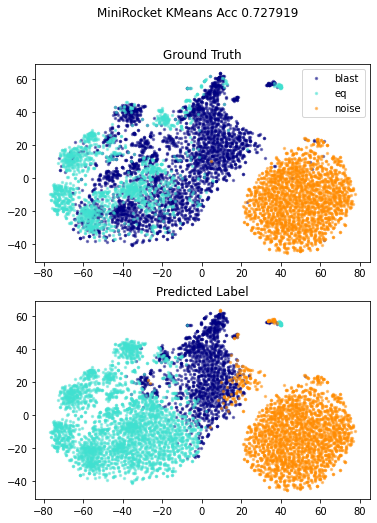

In [15]:
plotter(feature_2d, aligned_pred, y_test, target_names, train_valid_acc, 'MiniRocket KMeans', None, vis=True, anchors=None)